<a href="https://colab.research.google.com/github/syedmuneeb321/LangGraph-Explorations/blob/main/Getting_Started_With_LangGraph/agent_with_human_in_the_loop_part_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
%%capture --no-stderr
%pip install -U langgraph langsmith langchain_google_genai tavily-python langchain_community

In [8]:
import os
from google.colab import userdata

os.environ["LANGCHAIN_API_KEY"] = userdata.get('LANGCHAIN_API_KEY')
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "quickstart"
os.environ["TAVILY_API_KEY"] = userdata.get("TAVILY_API_KEY")

gemini_api_key = userdata.get('GOOGLE_API_KEY')

In [9]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",
    max_retries=2,
    api_key=gemini_api_key
)


In [10]:
from pydantic import BaseModel

class RequestAssistance(BaseModel):
  """
  Escalate the conversation to an expert. Use this if you are unable to assist directly or if the user requires support beyond your permissions.

  To use this function, relay the user's 'request' so the expert can provide the right guidance.
  """

  request: str


In [11]:
from langchain_community.tools import TavilySearchResults
tool = TavilySearchResults(max_results=2)
llm_with_tool = llm.bind_tools([tool,RequestAssistance])

In [12]:
display(llm_with_tool)

RunnableBinding(bound=ChatGoogleGenerativeAI(model='models/gemini-1.5-flash', google_api_key=SecretStr('**********'), max_retries=2, client=<google.ai.generativelanguage_v1beta.services.generative_service.client.GenerativeServiceClient object at 0x7d271e66f580>, default_metadata=()), kwargs={'tools': [{'type': 'function', 'function': {'name': 'tavily_search_results_json', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. Input should be a search query.', 'parameters': {'properties': {'query': {'description': 'search query to look up', 'type': 'string'}}, 'required': ['query'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'RequestAssistance', 'description': "Escalate the conversation to an expert. Use this if you are unable to assist directly or if the user requires support beyond your permissions.\n\nTo use this function, relay the user's 'request' so the exper

In [13]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages
# make a state
class State(TypedDict):
  messages: Annotated[list,add_messages]
  ask_human: bool

In [14]:
def chat_bot(state:State)->State:
  response = llm_with_tool.invoke(state["messages"])
  ask_human = False
  if (response.tool_calls and response.tool_calls[0]["name"] == RequestAssistance.__name__):
    ask_human = True


  return {"messages":[response],"ask_human":ask_human}

In [15]:
from langchain_core.messages import AIMessage, ToolMessage


def create_response(response: str, ai_message: AIMessage):
    return ToolMessage(
        content=response,
        tool_call_id=ai_message.tool_calls[0]["id"],
    )

In [16]:
def human_node(state:State)->State:
  new_messages = []
  if not isinstance(state["messages"][-1],ToolMessage):
     new_messages.append(
            create_response("No response from human.", state["messages"][-1])
      )

  return {
      "messages":new_messages,
      "ask_human":False
  }


In [17]:
from langgraph.prebuilt import ToolNode,tools_condition
def select_next_node(state:State):
  if state["ask_human"]:
    return "human_node"
  return tools_condition(state)

In [18]:
from langgraph.graph import StateGraph,START,END

from langgraph.checkpoint.memory import MemorySaver

graph_builder = StateGraph(State)

graph_builder.add_node("chat_bot",chat_bot)
graph_builder.add_node("tools",ToolNode(tools=[tool]))
graph_builder.add_node("human_node",human_node)

# logic

graph_builder.add_edge(START,"chat_bot")
graph_builder.add_conditional_edges("chat_bot",select_next_node,{"tools":"tools","human_node":"human_node",END:END})
graph_builder.add_edge("tools","chat_bot")
graph_builder.add_edge("human_node","chat_bot")


memory = MemorySaver()

app = graph_builder.compile(checkpointer=memory,interrupt_before=["human_node"])



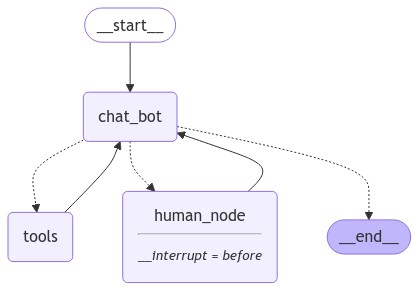

In [19]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [20]:
# input = {"messages":[("user","what is langgraph")]}
config = {"configurable":{"thread_id":"1"}}

In [21]:
events = app.stream({"messages":[("user","I need some expert guidance for building this AI agent. Could you request assistance for me?")]},config,stream_mode="values")
# events = graph.stream({"messages": [("user", user_input)]}, config)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I need some expert guidance for building this AI agent. Could you request assistance for me?
================================== Ai Message ==================================
Tool Calls:
  RequestAssistance (adbfa5ba-8b3e-46a2-aa01-881fd20213c5)
 Call ID: adbfa5ba-8b3e-46a2-aa01-881fd20213c5
  Args:
    request: I need some expert guidance for building this AI agent.


In [22]:
snapshot = app.get_state(config)
existing_message = snapshot.values["messages"][-1]
existing_message.pretty_print()



================================== Ai Message ==================================
Tool Calls:
  RequestAssistance (adbfa5ba-8b3e-46a2-aa01-881fd20213c5)
 Call ID: adbfa5ba-8b3e-46a2-aa01-881fd20213c5
  Args:
    request: I need some expert guidance for building this AI agent.


In [24]:
expert_message = "We, the experts are here to help! We'd recommend you check out LangGraph to build your agent.It's much more reliable and extensible than simple autonomous agents."

new_message = create_response(expert_message,existing_message)
app.update_state(config,{"messages":[new_message]})




{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef9c2fc-65c3-6905-8002-11100b3f5d8d'}}

In [25]:
snapshot = app.get_state(config)
snapshot.next

('human_node',)

In [26]:
events = app.stream(None,config,stream_mode="values")
# events = graph.stream({"messages": [("user", user_input)]}, config)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================= Tool Message =================================

We, the experts are here to help! We'd recommend you check out LangGraph to build your agent.It's much more reliable and extensible than simple autonomous agents.
================================= Tool Message =================================

We, the experts are here to help! We'd recommend you check out LangGraph to build your agent.It's much more reliable and extensible than simple autonomous agents.
================================== Ai Message ==================================

Okay, I've requested assistance from an expert. They recommend you check out LangGraph to build your AI agent. It's supposedly more reliable and extensible than simple autonomous agents.


In [27]:
snapshot = app.get_state(config)
snapshot.next

()